# 1. Preprocess the dataset

## 1.1 Extract frames from videos
My dataset is organized so that each top-level folder represents a gloss sentence. For instance:
```bash
VLS/
├── Ban_an_chua/     # Gloss: "Ban_an_chua"
│   ├── Signer01/
│   │   ├── video1.mp4
│   │   ├── video2.mp4
│   │   └── video3.mp4
│   ├── Signer02/
│   │   ├── video1.mp4
│   │   ├── video2.mp4
│   │   └── video3.mp4
│   ├── Signer03/
│   └── Signer04/
└── 7_gio_toi/       # Gloss: "7_gio_toi"
    ├── Signer01/
    │   ├── video1.mp4
    │   └── video2.mp4
    ├── Signer02/
    └── ...

```

To do that, I will write code following these steps:
1. Traverses dataset organized by gloss (e.g. "Ban_an_chua", "7_gio_toi").
2. For each gloss folder, iterates over all signer subfolders and their video files.
3. Creates one output folder per video, numbering them sequentially (0, 1, 2, …).
4. Extracts all frames from each video and saves them in folder `./data/interim`.
4. Extracts annotation for each folder and saves them in folder `./data/processed`.

The extracted frames will be saved in the following structure:
```bash
CSLR-VSL/data/interim/VSL_Sample
│── train/
│   ├── S000001_P0001_T01/
│   │   ├── frame_0000.jpg
│   │   ├── frame_0001.jpg
│   │   ├── ...
│   ├── S000001_P0001_T02/
│   ├── ...
│
│── test/
│   ├── S000001_P0002_T01/
│   ├── S000001_P0002_T02/
│   ├── ...
│
│── dev/
│   ├── S000001_P0001_T03/
│   ├── S000002_P0001_T03/
│   ├── ...

```

Where `S` is the **Sentence**, `P` is the **Person**, `T` is the **Trail**

I also save the annotation.csv for future uses in this bellow folder.
```bash
CSLR-VSL/data/processed/
│── train/
│   ├── VSL_Sample/csv
│   │   ├── train_annotations.csv
│   │   ├── test_annotations.csv
│   │   ├── dev_annotations.csv

```

In [202]:
import os
import cv2
import csv
from pathlib import Path
import re

def extract_frames(video_path, output_folder, sentence_id, signer_folder, trial_id, gloss_label, annotations):
    # Extract signer ID from the signer folder name
    signer_match = re.search(r'Signer(\d+)', str(signer_folder))
    signer_id = int(signer_match.group(1)) if signer_match else 0

    cap = cv2.VideoCapture(str(video_path))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    video_id = f"S{sentence_id:06d}_P{signer_id:04d}_T{trial_id:02d}"
    output_path = Path(output_folder) / video_id
    output_path.mkdir(parents=True, exist_ok=True)

    frame_index = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_filename = output_path / f"frame_{frame_index:04d}.png"
        cv2.imwrite(str(frame_filename), frame)
        frame_index += 1

    cap.release()
    print(f"Extracted {frame_count} frames from {video_path} → {output_path}")

    relative_path = output_path.relative_to(output_folder.parent)
    annotations.append([video_id, f"{relative_path}/", gloss_label])

def process_dataset(root_dir, output_dir, csv_dir, split):
    root_path = Path(root_dir) / split
    output_path = Path(output_dir) / split
    output_path.mkdir(parents=True, exist_ok=True)
    csv_path = Path(csv_dir)
    csv_path.mkdir(parents=True, exist_ok=True)

    annotations = []

    for sentence_index, sentence_folder in enumerate(sorted(root_path.iterdir())):
        if not sentence_folder.is_dir():
            continue

        sentence_id = sentence_index+1  # Ensure sequential numbering for sentences
        gloss_label = sentence_folder.name  # Use folder name as gloss label

        for signer_folder in sorted(sentence_folder.iterdir()):
            if not signer_folder.is_dir():
                continue

            for trial_index, video_file in enumerate(sorted(signer_folder.iterdir())):
                if video_file.suffix.lower() in {".mp4", ".mov", ".avi"}:
                    extract_frames(video_file, output_path, sentence_id, signer_folder, trial_index+1, gloss_label, annotations)

    save_annotations(annotations, csv_path / f"{split}_annotations.csv")

def save_annotations(annotations, csv_path):
    with open(csv_path, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Video_ID", "Frames_Path", "Gloss_Label"])
        writer.writerows(annotations)
    print(f"Annotations saved to {csv_path}")

if __name__ == "__main__":
    root_dir = Path("../data/raw/VSL_Sample")
    output_dir = Path("../data/interim/VSL_Sample")
    csv_dir = Path("../data/processed/VSL_Sample/csv")

    for split in ["train", "test", "dev"]:
        process_dataset(root_dir, output_dir, csv_dir, split)

    print("Frame extraction and annotation saving complete for all splits!")

Extracted 109 frames from /home/martinvalentine/Desktop/CSLR-VSL/data/raw/VSL_Sample/train/Ban keo bao_nhieu/Signer1/IMG_2167.MOV → /home/martinvalentine/Desktop/CSLR-VSL/data/interim/VSL_Sample/train/S000001_P0001_T01
Extracted 114 frames from /home/martinvalentine/Desktop/CSLR-VSL/data/raw/VSL_Sample/train/Ban keo bao_nhieu/Signer1/IMG_2168.MOV → /home/martinvalentine/Desktop/CSLR-VSL/data/interim/VSL_Sample/train/S000001_P0001_T02
Extracted 122 frames from /home/martinvalentine/Desktop/CSLR-VSL/data/raw/VSL_Sample/train/Ban keo bao_nhieu/Signer1/IMG_2169.MOV → /home/martinvalentine/Desktop/CSLR-VSL/data/interim/VSL_Sample/train/S000001_P0001_T03
Extracted 113 frames from /home/martinvalentine/Desktop/CSLR-VSL/data/raw/VSL_Sample/train/Ban keo bao_nhieu/Signer2 /IMG_2382.MOV → /home/martinvalentine/Desktop/CSLR-VSL/data/interim/VSL_Sample/train/S000001_P0002_T01
Extracted 126 frames from /home/martinvalentine/Desktop/CSLR-VSL/data/raw/VSL_Sample/train/Ban keo bao_nhieu/Signer2 /IMG_2

In [8]:
# Show the annotation
import pandas as pd
train_annotations = pd.read_csv("../data/processed/VSL_Sample/csv/train_annotations.csv")
test_annotations = pd.read_csv("../data/processed/VSL_Sample/csv/test_annotations.csv")
dev_annotations = pd.read_csv("../data/processed/VSL_Sample/csv/dev_annotations.csv")


In [203]:
# Train annotation
train_annotations

,Video_ID,Frames_Path,Gloss_Label
0,S000001_P0001_T01,train/S000001_P0001_T01/,Ban keo bao_nhieu
1,S000001_P0001_T02,train/S000001_P0001_T02/,Ban keo bao_nhieu
2,S000001_P0001_T03,train/S000001_P0001_T03/,Ban keo bao_nhieu
3,S000001_P0002_T01,train/S000001_P0002_T01/,Ban keo bao_nhieu
4,S000001_P0002_T02,train/S000001_P0002_T02/,Ban keo bao_nhieu
5,S000001_P0002_T03,train/S000001_P0002_T03/,Ban keo bao_nhieu
6,S000001_P0003_T01,train/S000001_P0003_T01/,Ban keo bao_nhieu
7,S000001_P0003_T02,train/S000001_P0003_T02/,Ban keo bao_nhieu
8,S000001_P0003_T03,train/S000001_P0003_T03/,Ban keo bao_nhieu
9,S000002_P0001_T01,train/S000002_P0001_T01/,Ban khoe khong


In [204]:
# Test annotation
test_annotations

,Video_ID,Frames_Path,Gloss_Label
0,S000001_P0004_T01,test/S000001_P0004_T01/,Ban keo bao_nhieu
1,S000001_P0004_T02,test/S000001_P0004_T02/,Ban keo bao_nhieu
2,S000001_P0004_T03,test/S000001_P0004_T03/,Ban keo bao_nhieu
3,S000002_P0004_T01,test/S000002_P0004_T01/,Ban khoe khong
4,S000002_P0004_T02,test/S000002_P0004_T02/,Ban khoe khong
5,S000002_P0004_T03,test/S000002_P0004_T03/,Ban khoe khong
6,S000003_P0004_T01,test/S000003_P0004_T01/,Toi bun_dau an thich
7,S000003_P0004_T02,test/S000003_P0004_T02/,Toi bun_dau an thich
8,S000003_P0004_T03,test/S000003_P0004_T03/,Toi bun_dau an thich
9,S000004_P0004_T01,test/S000004_P0004_T01/,Toi khoe


In [205]:
# Dev annotation
dev_annotations

,Video_ID,Frames_Path,Gloss_Label
0,S000001_P0003_T01,dev/S000001_P0003_T01/,Ban keo bao_nhieu
1,S000001_P0003_T02,dev/S000001_P0003_T02/,Ban keo bao_nhieu
2,S000001_P0003_T03,dev/S000001_P0003_T03/,Ban keo bao_nhieu
3,S000002_P0003_T01,dev/S000002_P0003_T01/,Ban khoe khong
4,S000002_P0003_T02,dev/S000002_P0003_T02/,Ban khoe khong
5,S000002_P0003_T03,dev/S000002_P0003_T03/,Ban khoe khong
6,S000003_P0003_T01,dev/S000003_P0003_T01/,Toi bun_dau an thich
7,S000003_P0003_T02,dev/S000003_P0003_T02/,Toi bun_dau an thich
8,S000003_P0003_T03,dev/S000003_P0003_T03/,Toi bun_dau an thich
9,S000004_P0003_T01,dev/S000004_P0003_T01/,Toi khoe


## 1.2 Generate the info dictionary
Before generating the gloss dictionary, I need to create a information dictionary that contains the following information:
- fileid: the unique ID of the video
- folder: the path pattern of the video frames
- signer: the signer of the video
- label: the gloss label
- num_frames: the number of frames in the video
- original_info: the original information string

In [201]:
cd /home/martinvalentine/Desktop/CSLR-VSL

/home/martinvalentine/Desktop/CSLR-VSL


In [259]:
import os
import pandas as pd
import numpy as np

# Define dataset paths
dataset_root = "../data/interim/VSL_Sample"
annotations_root = "../data/processed/csv"  # Folder containing annotation CSVs
frames_root = dataset_root  # Root directory for frame folders

# Define output directory for processed NumPy files
output_dir = "../data/processed/VSL_Sample"
os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

# Dataset splits
splits = ["train", "test", "dev"]

# Process each dataset split
for split in splits:
    # Locate annotation file
    annotations_path = os.path.join(annotations_root, f"{split}_annotations.csv")

    if not os.path.exists(annotations_path):
        print(f"Annotation file not found: {annotations_path}")
        continue  # Skip this split if the CSV is missing

    # Load annotation data
    df = pd.read_csv(annotations_path)

    info_dict = {}  # Store data in dictionary format

    for idx, row in df.iterrows():
        video_id = str(row["Video_ID"])  # Ensure string type
        frames_folder = os.path.join(frames_root, split, video_id)  # Absolute path to frames
        gloss = str(row["Gloss_Label"])  # Ensure string type

        # Validate frames folder
        if not os.path.exists(frames_folder):
            print(f"Warning: Frames folder not found → {frames_folder}")
            continue  # Skip this entry if the folder is missing

        # Count the number of PNG frames in the folder
        num_frames = len([f for f in os.listdir(frames_folder) if f.endswith(".png")])

        # Extract signer ID (Pxxxx from Sxxxxxx_Pxxxx_Txx)
        signer_id_extracted = video_id.split("_")[1]  # Extracts Pxxxx
        signer_id = f"signer{signer_id_extracted[1:]}"  # Convert Pxxxx to signerxxxx

        # Store structured data in dictionary format
        info_dict[idx] = {
            "fileid": video_id,                            # Unique file ID
            "folder": os.path.join(video_id, "*.png"),     # Folder path pattern
            "signer": signer_id,                           # Signer ID (Pxxxx)
            "label": gloss,                                # Label (gloss)
            "num_frames": num_frames,                      # Number of frames
            "original_info": f"{video_id}|{num_frames}|{gloss}"  # Original info string
        }

    # Save as a dictionary-based NumPy file (compatible with the second script)
    npy_output_path = os.path.join(output_dir, f"{split}_info.npy")
    np.save(npy_output_path, info_dict)

    print(f"Saved NumPy dictionary file for {split} → {npy_output_path}")

print("NumPy export complete!")


Saved NumPy dictionary file for train → /home/martinvalentine/Desktop/CSLR-VSL/data/processed/VSL_Sample/train_info.npy
Saved NumPy dictionary file for test → /home/martinvalentine/Desktop/CSLR-VSL/data/processed/VSL_Sample/test_info.npy
Saved NumPy dictionary file for dev → /home/martinvalentine/Desktop/CSLR-VSL/data/processed/VSL_Sample/dev_info.npy
NumPy export complete!


In [7]:
import numpy as np
import os

# Define the processed data directory
output_dir = "../data/processed/VSL_Sample"

# Dataset splits
splits = ["train", "test", "dev"]

for split in splits:
    npy_file_path = os.path.join(output_dir, f"{split}_info.npy")

    if not os.path.exists(npy_file_path):
        print(f"\nFile not found: {npy_file_path}\n")
        continue

    # Load the NumPy dictionary
    data = np.load(npy_file_path, allow_pickle=True).item()  # Convert to dictionary

    print(f"\nLoaded {split.capitalize()} Data (Showing 3 Samples)\n" + "="*50)

    # Print only 3 entries, formatted nicely
    for idx, (key, value) in enumerate(data.items()):
        print(f"Video ID: {value['fileid']}")
        print(f"Folder: {value['folder']}")
        print(f"Signer: {value['signer']}")
        print(f"Gloss: {value['label']}")
        print(f"Frames: {value['num_frames']}")
        print(f"Info: {value['original_info']}")
        print("-" * 50)
        if idx == 2:  # Show only 3 entries
            break



Loaded Train Data (Showing 3 Samples)
Video ID: S000001_P0001_T01
Folder: S000001_P0001_T01/*.png
Signer: signer0001
Gloss: Ban keo bao_nhieu
Frames: 109
Info: S000001_P0001_T01|109|Ban keo bao_nhieu
--------------------------------------------------
Video ID: S000001_P0001_T02
Folder: S000001_P0001_T02/*.png
Signer: signer0001
Gloss: Ban keo bao_nhieu
Frames: 114
Info: S000001_P0001_T02|114|Ban keo bao_nhieu
--------------------------------------------------
Video ID: S000001_P0001_T03
Folder: S000001_P0001_T03/*.png
Signer: signer0001
Gloss: Ban keo bao_nhieu
Frames: 122
Info: S000001_P0001_T03|122|Ban keo bao_nhieu
--------------------------------------------------

Loaded Test Data (Showing 3 Samples)
Video ID: S000001_P0004_T01
Folder: S000001_P0004_T01/*.png
Signer: signer0004
Gloss: Ban keo bao_nhieu
Frames: 119
Info: S000001_P0004_T01|119|Ban keo bao_nhieu
--------------------------------------------------
Video ID: S000001_P0004_T02
Folder: S000001_P0004_T02/*.png
Signer: sig

## 1.4 Generate the gloss dictionary
The gloss dictionary will be a Python dictionary that maps each unique gloss to an integer ID. The dictionary will be saved as a `.npy` file.

In [263]:
import os
import numpy as np
from tqdm import tqdm

# Define the paths for input and output files
info_dict_paths = [
    "../data/processed/VSL_Sample/train_info.npy",
    "../data/processed/VSL_Sample/dev_info.npy",
    "../data/processed/VSL_Sample/test_info.npy",
]
gloss_dict_path = "../data/processed/VSL_Sample/gloss_dict.npy"

# Initialize gloss dictionary
gloss_dict = {}
next_id = 1  # Start from 1, as 0 is reserved for the blank token

# Process each info_dict file
for info_dict_path in info_dict_paths:
    print(f"Processing: {info_dict_path}")
    info_dict = np.load(info_dict_path, allow_pickle=True).item()

    for key, value in info_dict.items():
        # Process only video entries (keys that are integers)
        if not isinstance(key, int):
            continue

        # Split the label by whitespace; if the label contains multiple tokens, count each separately
        tokens = value['label'].split()
        for token in tokens:
            token = token.strip()
            if not token:
                continue
            if token not in gloss_dict:
                gloss_dict[token] = [next_id, 1]  # [Gloss ID, Occurrence Count]
                next_id += 1
            else:
                gloss_dict[token][1] += 1  # Increment occurrence count


Processing: /home/martinvalentine/Desktop/CSLR-VSL/data/processed/VSL_Sample/train_info.npy
Processing: /home/martinvalentine/Desktop/CSLR-VSL/data/processed/VSL_Sample/dev_info.npy
Processing: /home/martinvalentine/Desktop/CSLR-VSL/data/processed/VSL_Sample/test_info.npy


In [264]:
gloss_dict

{'Ban': [1, 30],
 'keo': [2, 15],
 'bao_nhieu': [3, 15],
 'khoe': [4, 30],
 'khong': [5, 15],
 'Toi': [6, 30],
 'bun_dau': [7, 15],
 'an': [8, 15],
 'thich': [9, 15]}

In [265]:
# Save the gloss_dict as a .npy file
np.save(gloss_dict_path, gloss_dict)

In [5]:
pwd

'/home/martinvalentine/Desktop/CSLR-VSL/notebooks'

In [6]:
import os
import numpy as np

file_path = '../data/processed/VSL_Sample/gloss_dict.npy'

if os.path.exists(file_path):
    gloss_dict = np.load(file_path, allow_pickle=True).item()
    print("File loaded successfully.")
else:
    print(f"File not found: {file_path}")

File loaded successfully.


In [11]:
# Count the number of unique labels
num_labels = len(gloss_dict)
print(f"Total unique labels in gloss_dict: {num_labels}")

Total unique labels in gloss_dict: 9


## 1.5 Generate the ground truth STM file

Next, we need to generate the ground truth STM file. The STM file is a text file that contains the ground truth information for the dataset. Each line in the file represents a segment of the video with the following format:
```python
{fileid} 1 {starttime} {endtime} {label}
```
Where:
- `fileid`: A unique identifier for the video or video segment.
- `1`: A placeholder for the channel identifier.
- `signer`: The identifier for the signer (if available; you can use a default value if not).
- `start_time`: The starting timestamp (often 0.0 if unknown).
- `end_time`: The ending timestamp (often a large number like 1.79769e+308 to indicate the full duration).
- `label`: The gloss (annotation) for that segment.

Because I have mixed my dataset videos of each signer so I will use `UnknownSigner` as a placeholder for the signer.

In [274]:
import numpy as np
import os

def generate_gt_stm(info_dict, save_path):
    """
    Generate STM file from a dictionary of video metadata.

    Args:
        info_dict (dict): Dictionary containing video metadata.
        save_path (str): Path to save the STM file.
    """
    with open(save_path, "w") as f:
        for k, v in info_dict.items():
            if not isinstance(k, int):  # Ensure key is an integer index
                continue
            f.writelines(f"{v['fileid']} 1 {v['signer']} 0.0 1.79769e+308 {v['label'].upper()}\n")  # Uppercase labels

    print(f"Ground truth STM saved to {save_path}")

# Define dataset splits
splits = ["train", "dev", "test"]
base_path = "../data/processed/VSL_Sample"
output_dir = "../data/processed/VSL_Sample"  # Output directory for STM files

os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists

for split in splits:
    info_file_path = os.path.join(base_path, f"{split}_info.npy")
    output_stm_path = os.path.join(output_dir, f"vsl-ground-truth-{split}.stm")

    if not os.path.exists(info_file_path):
        print(f"File not found: {info_file_path}")
        continue

    # Load the NumPy file as a dictionary
    info_dict = np.load(info_file_path, allow_pickle=True).item()

    if not isinstance(info_dict, dict):
        print(f"Warning: {info_file_path} is not a dictionary. Skipping.")
        continue

    # Generate STM file
    generate_gt_stm(info_dict, output_stm_path)


✅ Ground truth STM saved to /home/martinvalentine/Desktop/CSLR-VSL/data/processed/VSL_Sample/vsl-ground-truth-train.stm
✅ Ground truth STM saved to /home/martinvalentine/Desktop/CSLR-VSL/data/processed/VSL_Sample/vsl-ground-truth-dev.stm
✅ Ground truth STM saved to /home/martinvalentine/Desktop/CSLR-VSL/data/processed/VSL_Sample/vsl-ground-truth-test.stm


Next, I will resize the images to a 256x256 resolution. This is a common size for image-based models and will help reduce the computational requirements for training.

## 1.6 Resize the images

I will resize the images to a resolution of 256x256 pixels. This will help standardize the image sizes and reduce the computational requirements for training the model.


In [273]:
import cv2
import os
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Optional, Tuple

def resize_img(img_path: str, dsize: Tuple[int, int] = (256, 256)) -> Optional[np.ndarray]:
    """
    Resize an image with error handling and high-quality interpolation.

    Args:
        img_path (str): Path to the input image.
        dsize (Tuple[int, int]): Desired output image size. Defaults to (256, 256).

    Returns:
        Optional[np.ndarray]: Resized image or None if processing fails.
    """
    try:
        # Use more efficient image reading
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        if img is None:
            print(f"Error: Could not read image {img_path}")
            return None

        # Handle grayscale images
        if len(img.shape) < 3:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # Resize with advanced interpolation
        resized_img = cv2.resize(img, dsize, interpolation=cv2.INTER_LANCZOS4)
        return resized_img

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

def process_split(source_folder: str, destination_folder: str, split: str, max_workers: int = 8) -> None:
    """
    Process a specific data split with parallel image processing.

    Args:
        source_folder (str): Source directory for the split.
        destination_folder (str): Destination directory for processed images.
        split (str): Data split name (train/test/dev).
        max_workers (int): Maximum number of parallel workers.
    """
    split_source = os.path.join(source_folder, split)
    split_destination = os.path.join(destination_folder, split)

    # Collect image paths
    image_paths = []
    for root, _, files in os.walk(split_source):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                src_path = os.path.join(root, file)
                image_paths.append((src_path, split_source, split_destination))

    # Process images in parallel
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {}
        for src_path, base_source, base_destination in image_paths:
            future = executor.submit(process_single_image, src_path, base_source, base_destination)
            futures[future] = src_path

        # Handle results with progress tracking
        for future in as_completed(futures):
            try:
                future.result()
            except Exception as e:
                print(f"Error processing {futures[future]}: {e}")

def process_single_image(src_path: str, base_source: str, base_destination: str) -> None:
    """
    Process a single image, maintaining directory structure.

    Args:
        src_path (str): Source image path.
        base_source (str): Base source directory.
        base_destination (str): Base destination directory.
    """
    # Generate destination path while preserving folder structure
    rel_path = os.path.relpath(os.path.dirname(src_path), base_source)
    dst_dir = os.path.join(base_destination, rel_path)
    os.makedirs(dst_dir, exist_ok=True)

    dst_path = os.path.join(dst_dir, os.path.basename(src_path))

    # Resize and save image
    resized_img = resize_img(src_path)
    if resized_img is not None:
        cv2.imwrite(dst_path, resized_img)

if __name__ == "__main__":
    """
    Main function to orchestrate image resizing across splits.
    """
    source_folder = "../data/interim/VSL_Sample"
    destination_folder = "../data/processed/features/VSL_Sample_256x256"

    # Ensure destination folder exists
    os.makedirs(destination_folder, exist_ok=True)

    # Process splits
    splits = ["train", "test", "dev"]
    for split in splits:
        print(f"Processing {split} split...")
        process_split(source_folder, destination_folder, split)

    print("\nImage resizing complete for all splits!")


Processing train split...
Processing test split...
Processing dev split...

Image resizing complete for all splits!


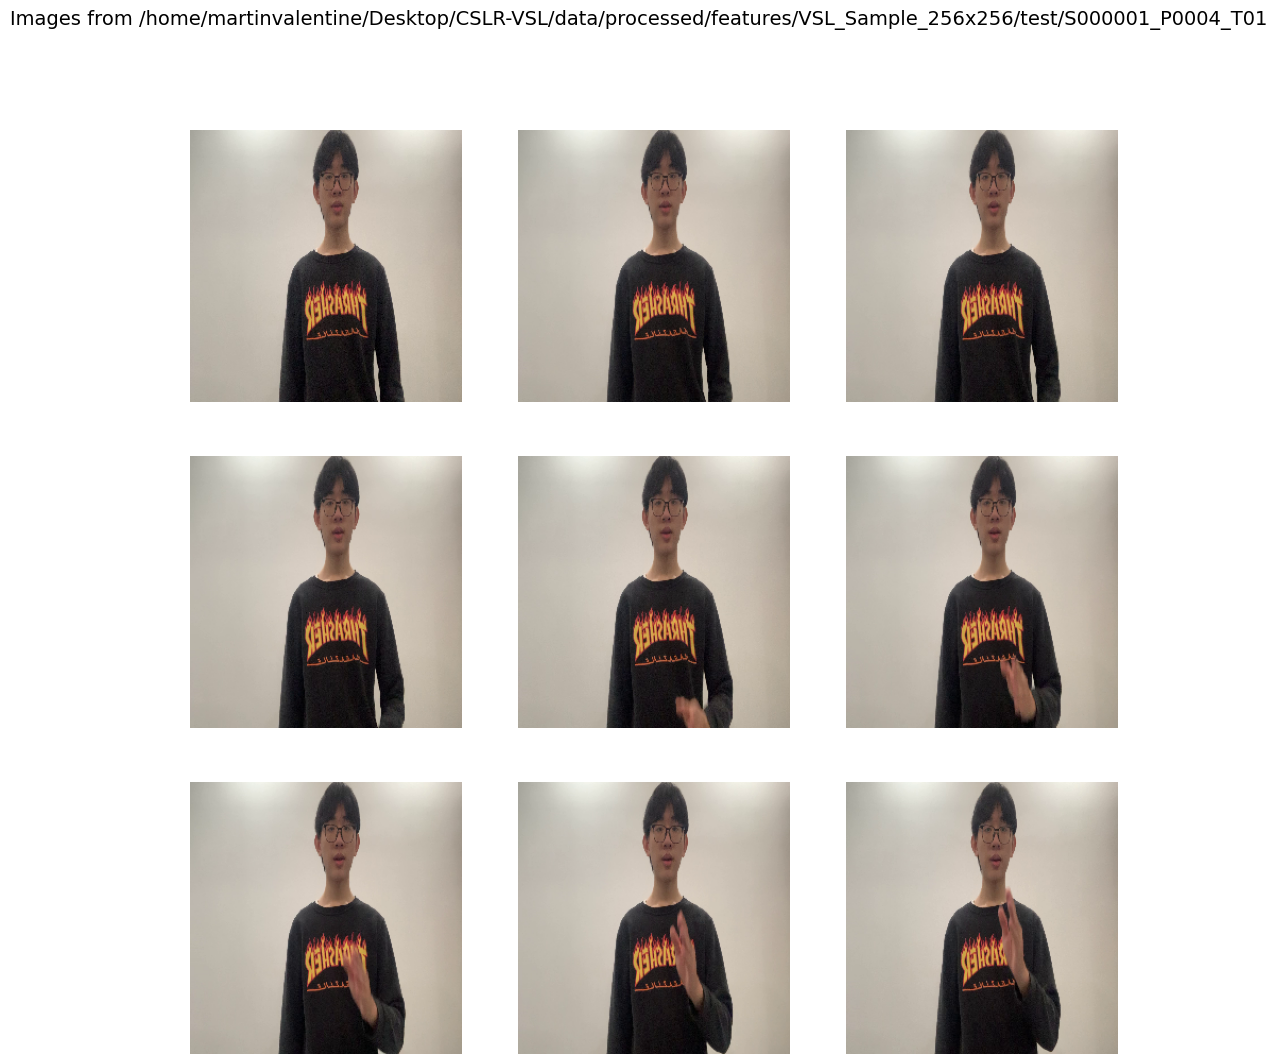

In [10]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# Define the image folder path
image_folder = "/home/martinvalentine/Desktop/CSLR-VSL/data/processed/features/VSL_Sample_256x256/test/S000001_P0004_T01"

# Get the list of resized images
resized_images = sorted(glob.glob(os.path.join(image_folder, "*.png")))

# Check if images exist
if not resized_images:
    raise ValueError(f"No images found in '{image_folder}'")

# Limit to 9 images (or however many exist)
num_images = min(len(resized_images), 9)

# Plot the images
plt.figure(figsize=(12, 12))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    img = mpimg.imread(resized_images[i])
    plt.imshow(img)
    plt.axis("off")

plt.suptitle(f"Images from {image_folder}", fontsize=14)
plt.show()


We have successfully resized the images to 256x256 pixels. The preprocessing steps are now complete.

In [276]:
# GENERATE SPLIT.TXT
import os

# Define paths to your dataset folders
dataset_root = "../data/processed/VSL_Sample/VSL_256x256"
splits = ["train", "dev", "test"]

# Define output file path
split_file_path = os.path.join(dataset_root, "split.txt")

# Open file for writing
with open(split_file_path, "w") as f:
    f.write("fileid|split\n")  # Header row

    for split in splits:
        split_folder = os.path.join(dataset_root, split)

        # Scan subdirectories
        for folder in os.listdir(split_folder):
            folder_path = os.path.join(split_folder, folder)

            if os.path.isdir(folder_path):  # Only process directories
                f.write(f"{folder}|{split}\n")

print(f"✅ Split file saved to {split_file_path}")


✅ Split file saved to /home/martinvalentine/Desktop/CSLR-VSL/data/processed/VSL_Sample/VSL_256x256/split.txt
